In [2]:
import os
import sqlite3 as sql
import pandas as pd
import numpy as np
from bokeh.events import Tap
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.close('all')    
plt.ion()
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import date
import seaborn as sns
sns.set()
import pandas as pd
%matplotlib inline

In [3]:
today = date.today()
d1 = today.strftime("%d/%m/%Y")
d1

'07/11/2022'

In [4]:
nc=11
cmap = plt.cm.get_cmap('Reds', nc)
#cmap.set_bad(color = 'k', alpha = .5)
cmap.set_under('0.99')
#bounds=list(range(1,int(a.max().max()), int(a.max().max()/nc)))
bounds=list(range(1,66,int(66./nc)))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cob=ax.pcolormesh(a.values.T, cmap=cmap)

NameError: name 'ax' is not defined

# Full manual ESGF search

The lines below query the ESGF RESTful API to retrieve a json of relevant data listings. These are then used to generate the figure. This is the same approach used by James' `search-esgf`, but here very condensed just to retrieve the desired results inline.

In [50]:
import urllib.request, json 

data = []
for i in np.arange(50):
    offset=10000*i
    urlin = f'https://esgf-node.llnl.gov/esg-search/search?project=CMIP6&latest=true&replica=false&format=application%2Fsolr%2Bjson&limit=10000&variable_id=tas&table_id=Amon&offset={offset}'
    with urllib.request.urlopen(urlin) as url:
        data_tmp = json.loads(url.read().decode())
        data = data + data_tmp['response']['docs']

In [51]:
my_keys = ['activity_id', 'experiment_id','frequency', 'institution_id', 'member_id', 
           'size', 'source_id', 'sub_experiment_id', 'table_id','variable_id', 'variant_label']

parsed = []
for doc in data:
    parsed.append({key: doc[key][0] if type(doc[key])==list else doc[key] for key in my_keys})

In [52]:
df = pd.DataFrame(parsed)

In [53]:
# Load data from a local "search-esgf" summary file
d2 = df.groupby(['source_id', 'experiment_id', 'activity_id']
               ).agg({"member_id": "nunique"}).groupby(
    ['source_id','activity_id']).sum().unstack().sort_index(axis=1, ascending=False)
mpl.rcParams.update({'font.size': 8})
a = d2

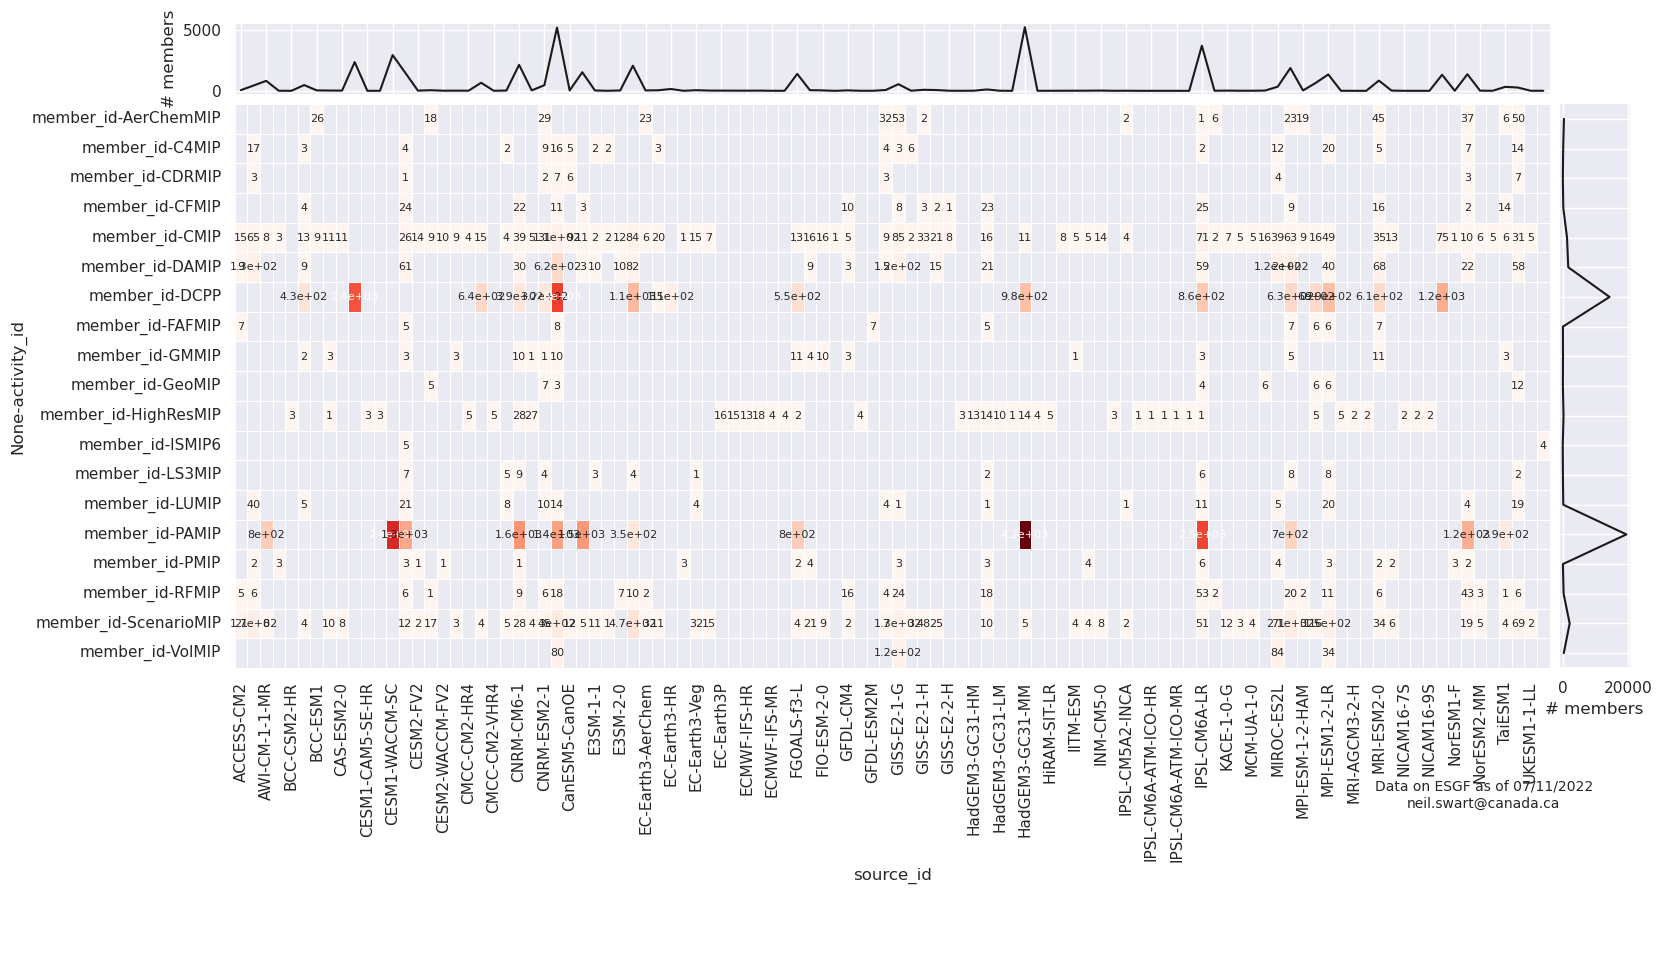

In [54]:
fig, ax = plt.subplots(1,1,figsize=(18,12))
mpl.rcParams.update({'font.size': 8})

sns.heatmap(a.T, annot=True, linewidth=0.5, ax=ax, cmap='Reds', cbar=False)

divider = make_axes_locatable(ax)
ax_x = divider.append_axes("top", 0.7, pad=0.1, sharex=ax)
ax_y = divider.append_axes("right", 0.7, pad=0.1, sharey=ax)
ax_c = divider.append_axes("bottom", 0.05, pad=2.75)

# make some labels invisible
ax_x.xaxis.set_tick_params(labelbottom=False)
ax_y.yaxis.set_tick_params(labelleft=False)
ax_x.plot(np.arange(len(a))+0.5, a.fillna(0).values.T.sum(axis=0), 'k')
ax_y.plot(a.fillna(0).values.T.sum(axis=1),np.arange(len(a.columns))+0.5, 'k')
ax_x.set_xlim([0, len(a)])
ax_y.set_ylim([0, len(a.columns)])
ax_y.set_xlabel('# members')
ax_x.set_ylabel('# members')
ax_x.spines['top'].set_visible(False)
ax_x.spines['right'].set_visible(False)
ax_x.spines['bottom'].set_visible(False)
ax_y.spines['right'].set_visible(False)
ax_y.spines['left'].set_visible(False)
ax_y.spines['top'].set_visible(False)

ax_c.axis('off')
#plt.colorbar(cob, ax=ax_c, label='# members', orientation='horizontal', norm=norm, 
#             boundaries=[0]+bounds, fraction=0.1)

ax.text(0.95, -0.21, f'Data on ESGF as of {d1}', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes, fontsize=10)
ax.text(0.95, -0.24, 'neil.swart@canada.ca', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes, fontsize=10)

dd1 = d1.replace('/','-')
fig.savefig(f'CMIP6-members-by-model-activity-{dd1}.png', dpi=300, bbox_inches='tight')

In [55]:
#d2 = df[ (df.activity_id=='CMIP') | (df.activity_id=='ScenarioMIP') | (df.activity_id=='DAMIP')].groupby(['source_id','experiment_id']).agg({"member_id": "nunique"}).unstack().sort_index(axis=1, ascending=False)
d2 = df[(df.activity_id=='ScenarioMIP')].groupby(['source_id','experiment_id']).agg({"member_id": "nunique"}).unstack().sort_index(axis=1, ascending=False)
a = d2

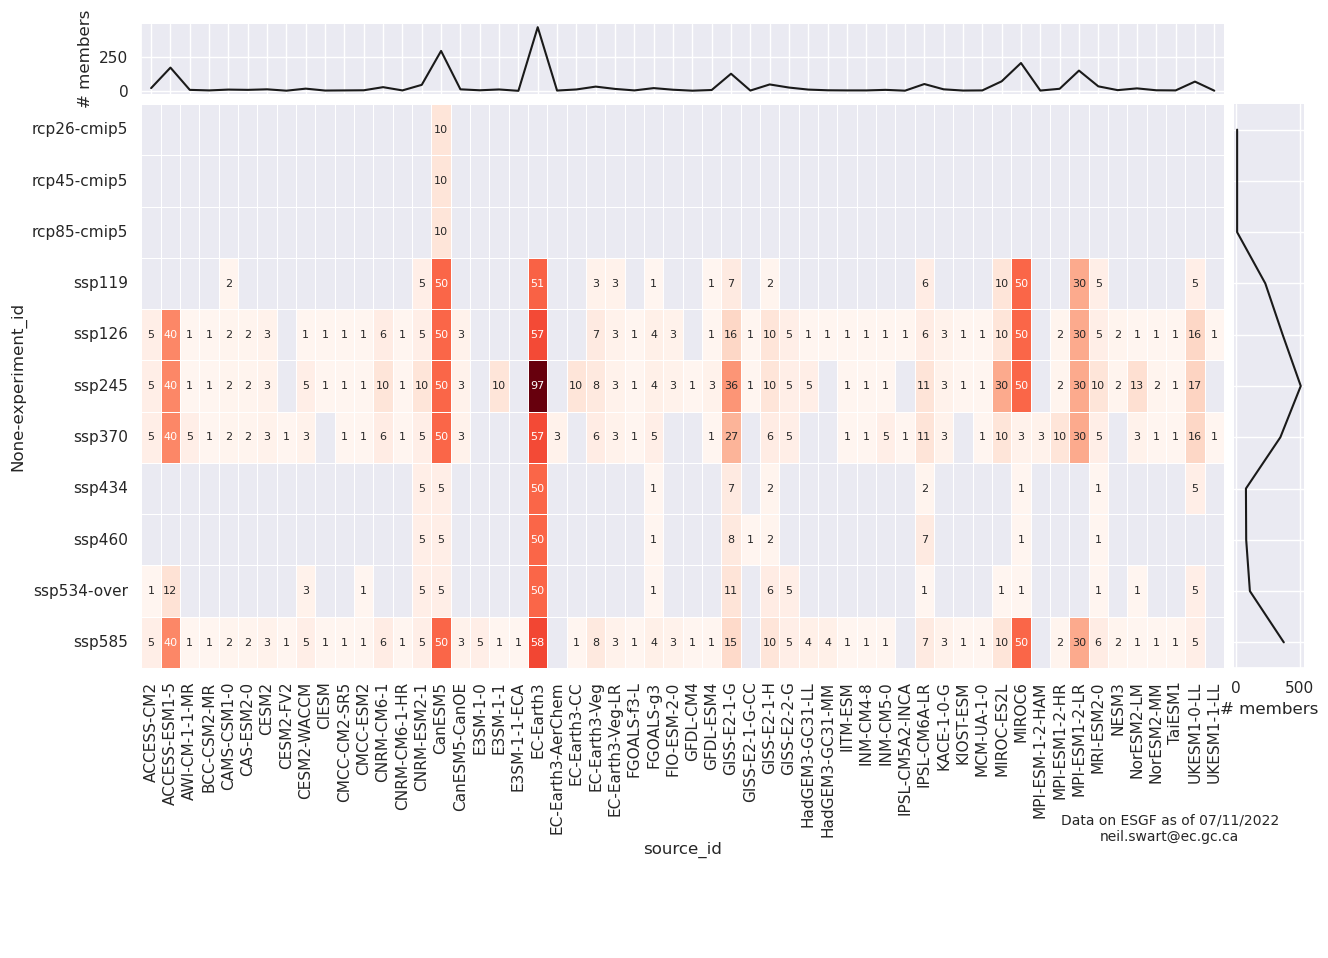

In [56]:
fig, ax = plt.subplots(1,1,figsize=(15,12))
mpl.rcParams.update({'font.size': 8})

cob=sns.heatmap(a.T, annot=True, linewidth=0.5, ax=ax, cmap='Reds', cbar=False)

divider = make_axes_locatable(ax)
ax_x = divider.append_axes("top", 0.7, pad=0.1, sharex=ax)
ax_y = divider.append_axes("right", 0.7, pad=0.1, sharey=ax)
ax_c = divider.append_axes("bottom", 0.05, pad=2.75)

# make some labels invisible
ax_x.xaxis.set_tick_params(labelbottom=False)
ax_y.yaxis.set_tick_params(labelleft=False)
ax_x.plot(np.arange(len(a))+0.5, a.fillna(0).values.T.sum(axis=0), 'k')
ax_y.plot(a.fillna(0).values.T.sum(axis=1),np.arange(len(a.columns))+0.5, 'k')
ax_x.set_xlim([0, len(a)])
ax_y.set_ylim([0, len(a.columns)])
ax_y.set_xlabel('# members')
ax_x.set_ylabel('# members')
ax_x.spines['top'].set_visible(False)
ax_x.spines['right'].set_visible(False)
ax_x.spines['bottom'].set_visible(False)
ax_y.spines['right'].set_visible(False)
ax_y.spines['left'].set_visible(False)
ax_y.spines['top'].set_visible(False)

ax_c.axis('off')
#plt.colorbar(cob, ax=ax_c, label='# members', orientation='horizontal', norm=norm, 
#             boundaries=[0]+bounds, fraction=0.1)

ax.text(0.95, -0.27, f'Data on ESGF as of {d1}', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes, fontsize=10)
ax.text(0.95, -0.3, 'neil.swart@ec.gc.ca', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes, fontsize=10)

labels = [item.get_text() for item in ax.get_yticklabels()]
lout = []
for l in labels:
    lout.append(l.replace('member_id-',''))

ax.set_yticklabels(lout)
fig.savefig('CMIP6-members-scenariomip.png', dpi=300, bbox_inches='tight')


In [58]:
a.T.sum()

source_id
ACCESS-CM2            21.0
ACCESS-ESM1-5        172.0
AWI-CM-1-1-MR          8.0
BCC-CSM2-MR            4.0
CAMS-CSM1-0           10.0
CAS-ESM2-0             8.0
CESM2                 12.0
CESM2-FV2              2.0
CESM2-WACCM           17.0
CIESM                  3.0
CMCC-CM2-SR5           4.0
CMCC-ESM2              5.0
CNRM-CM6-1            28.0
CNRM-CM6-1-HR          4.0
CNRM-ESM2-1           45.0
CanESM5              295.0
CanESM5-CanOE         12.0
E3SM-1-0               5.0
E3SM-1-1              11.0
E3SM-1-1-ECA           1.0
EC-Earth3            470.0
EC-Earth3-AerChem      3.0
EC-Earth3-CC          11.0
EC-Earth3-Veg         32.0
EC-Earth3-Veg-LR      15.0
FGOALS-f3-L            4.0
FGOALS-g3             21.0
FIO-ESM-2-0            9.0
GFDL-CM4               2.0
GFDL-ESM4              7.0
GISS-E2-1-G          127.0
GISS-E2-1-G-CC         3.0
GISS-E2-1-H           48.0
GISS-E2-2-G           25.0
HadGEM3-GC31-LL       10.0
HadGEM3-GC31-MM        5.0
IITM-ESM          